In [1]:
import os

dataFiles = []
for root, dirs, files in os.walk("Data2"):
    for file in files:
        path = os.path.join(root, file)
        dataFiles.append(path)

In [2]:
%load_ext autoreload
%autoreload 2

In [18]:
from keras import activations

hyperparameters = {
    "UseAdjectives": False,
    "MinKeywordOccurrences": 10,
    "MaxKeywordOccurrences": 500,
    "EncoderHiddenDimensions": 64,
    "EncoderLatentDimensions": 2,
    "EncoderHiddenActivation": activations.relu,
    "EncoderLatentActivation": activations.relu,
    "DecoderHiddenDimensions": 64,
    "DecoderHiddenActivation": activations.relu,
    "DecoderFinalActivation": activations.sigmoid,
    "EncoderEpochs" : 75,
    "SVMKernel": 'rbf',
    "gamma": 'auto'
}

In [9]:
import movie_reviews
from gensim import downloader

# read from the Data2 folder to get names of movies for training data
movies = movie_reviews.get_movies_from_binaries(dataFiles)

# get the IMDb Ids of as many of these movies as possible
movies_by_id = movie_reviews.unpickle("movies_by_id.bin")
if not movies_by_id:
    movies_by_id = movie_reviews.get_movie_ids(movies)
ids = list(movies_by_id.keys())

# get the plots of as many movies as possible, update which Ids have plots
plots_by_id = movie_reviews.unpickle("plots_by_id.bin")
if not plots_by_id:
    plots_by_id = movie_reviews.get_movie_plots(ids)
ids = list(plots_by_id.keys())

# get the keywords in each plot and convert them into keyword vectors for each movie
keywords_by_id = movie_reviews.get_plots_keywords(plots_by_id, adjectives=hyperparameters["UseAdjectives"])
keyword_counts = movie_reviews.get_keyword_counts(keywords_by_id)
trimmed_keywords = movie_reviews.trim_keyword_list(keyword_counts, min_occurrences=hyperparameters["MinKeywordOccurrences"], max_occurrences=hyperparameters["MaxKeywordOccurrences"])
keyword_vectors = movie_reviews.get_movie_keyword_vectors(trimmed_keywords, keywords_by_id)

# get the genres for every movie that has an available plot
# genres_by_id = movie_reviews.unpickle("genres_by_id.bin")
# if not genres_by_id:
#     genres_by_id = movie_reviews.get_movies_genres(ids)
# ids = list(genres_by_id.keys())

# # get genre vectors as potential features to train encoder with
# master_genre_list = movie_reviews.get_genres_list(genres_by_id)
# genre_feature_count = len(master_genre_list)
# genre_vectors = movie_reviews.get_movies_genre_vectors(master_genre_list, genres_by_id)

# # load pretrained word2Vec model if not already loaded
# try:
#     word2Vec
# except:
#     word2Vec = downloader.load("word2vec-google-news-300")

# keyword_word2vec_vectors = movie_reviews.get_word2vec_movie_vectors(trimmed_keywords, keyword_vectors, word2Vec)
# genre_word2vec_vectors = movie_reviews.get_word2vec_movie_vectors(master_genre_list, genre_vectors, word2Vec)


In [5]:
# quantify the sparsity of the keyword vectors
keyword_vector_sums = {}
average_keywords = 0
for id, keyword_vector in keyword_vectors.items():
    s = sum(keyword_vector)
    keyword_vector_sums[id] = s
    average_keywords += s
average_keywords /= len(keyword_vector_sums)
print(f"Average keywords in plot: {average_keywords}")
print(f"Total keywords possible: {len(trimmed_keywords)}")

Average keywords in plot: 144.0880733944954
Total keywords possible: 4886


In [19]:
import numpy as np

# get keyword vectors as training features for an autoencoder
input_features = []
for _, vec in keyword_vectors.items():
    input_features.append(vec)
input_features = np.array(input_features)

# create and train the autoencoder
autoencoder = movie_reviews.Autoencoder(len(trimmed_keywords), hyperparameters)
autoencoder.fit(x = input_features, y = input_features, epochs = hyperparameters["EncoderEpochs"], shuffle = True)

Epoch 1/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1558
Epoch 2/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0312
Epoch 3/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0306
Epoch 4/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293
Epoch 5/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292
Epoch 6/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295
Epoch 7/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0301
Epoch 8/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296
Epoch 9/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295
Epoch 10/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0289
Epoch 11/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0289
Epoch 12/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0291
Epoch 13/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0294
Epoch 14/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0291
Epoch 15/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0293
Epoch 16/75
69/69 ━

In [20]:
encoded = autoencoder.encoder(input_features).numpy()

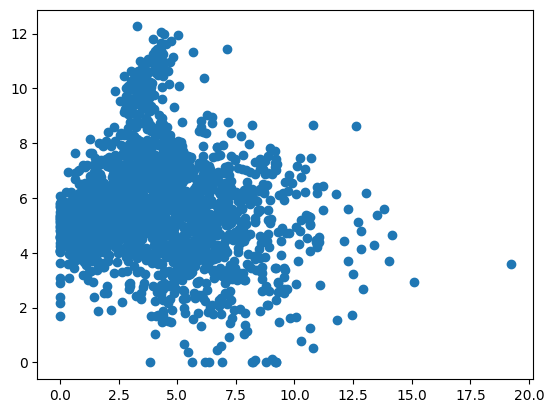

In [21]:
import matplotlib.pyplot as plt

x = encoded[:, 0]
y = encoded[:, 1]

plt.scatter(x, y)
#plt.xscale('log')
#plt.yscale('log')
plt.show()

In [ ]:
User = movie_reviews.get_user_preferences("Trevor.txt")

user_ids = list(User.keys())
user_plots = movie_reviews.get_movie_plots(user_ids)

user_keywords = movie_reviews.get_plots_keywords(user_plots, adjectives=hyperparameters["UseAdjectives"])
user_keyword_vectors = movie_reviews.get_movie_keyword_vectors(trimmed_keywords, user_keywords)


In [37]:
user_features = []
for _, vec in user_keyword_vectors.items():
    user_features.append(vec)
user_features = np.array(user_features)

user_encoded = autoencoder.encoder(user_features).numpy()
user_encoded_by_id = {}
for id, encoded in zip(user_ids, user_encoded):
    user_encoded_by_id[id] = encoded

liked = []
disliked = []
for id, encoded in user_encoded_by_id.items():
    if User[id] == 1:
        liked.append(encoded)
    elif User[id] == 0:
        disliked.append(encoded)
liked = np.array(liked)
disliked = np.array(disliked)

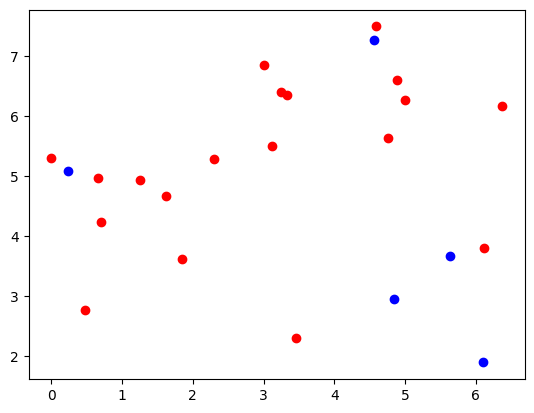

In [38]:
liked_x = liked[:, 0]
liked_y = liked[:, 1]
disliked_x = disliked[:, 0]
disliked_y = disliked[:, 1]

plt.scatter(liked_x, liked_y, color='red')
plt.scatter(disliked_x, disliked_y, color='blue')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

In [173]:
from sklearn import svm

pos_2 = svm.OneClassSVM(kernel=hyperparameters['SVMKernel'], gamma=hyperparameters['gamma'])
neg_2 = svm.OneClassSVM(kernel=hyperparameters['SVMKernel'], gamma=hyperparameters['gamma'])
pos_3 = svm.OneClassSVM(kernel=hyperparameters['SVMKernel'], gamma=hyperparameters['gamma'])
neg_3 = svm.OneClassSVM(kernel=hyperparameters['SVMKernel'], gamma=hyperparameters['gamma'])

user_model_2 = movie_reviews.train_user_model(pos_2, neg_2, features_2, User)
user_model_3 = movie_reviews.train_user_model(pos_3, neg_3, features_3, User)